# Ensuring Fairness in Regression Tasks

This tutorial will focus on a real-world learning-with-constraint application.

We will use the Moving Targets' APIs to train a `LinearRegression` learner while imposing a constraint on the whole sampled population leveraging the `RegressionMaster` template class. Our aim is indeed to satisfy ethical requirements via a metric for statistical fairness, namely the [**Disparate Impact Discrimination Index** ($\mbox{DIDI}$)](https://arxiv.org/abs/1903.10598), so to reduce the level of both explicit and implicit discrimination learned by the model.

> NOTE: since we will leverage on the [Gurobi](https://www.gurobi.com/) solver to deal with the master problem, you will need to install it separately. A free academic license for the solver can be obtained [here](https://www.gurobi.com/academia/academic-program-and-licenses/). Otherwise, you may change the line of code involving the backend object and use one among the other supported backends.

In [1]:
import numpy as np
import seaborn as sns

np.random.seed(0)
sns.set_style('whitegrid')
sns.set_context('notebook')

## The Communities & Crime Dataset

Our regression task will be based upon the **Communities & Crime** dataset, in which the aim is to estimate the risk of violent crimes within a certain neighbourhood. The original version of the dataset can be found on the [UCI Repository](https://archive.ics.uci.edu/ml/datasets/communities+and+crime), but we will use a preprocessed version that can be found in the official Moving Targets' [github repository](https://github.com/moving-targets/moving-targets).

While trying to maximize the predictive capabilities of our model, we aim as well at reducing the discrimination based on a protected categorical feature, i.e., **race** (*0* = primarily white neighbourhood, *1* = primarily black neighbourhood).

In [2]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/moving-targets/moving-targets/main/res/communities.csv')
df.describe()

,pop,race,perHoush,pctBlack,pctWhite,pctAsian,pctHisp,pct12-21,pct12-29,pct16-24,...,pctForeignBorn,pctBornStateResid,pctSameHouse-5,pctSameCounty-5,pctSameState-5,landArea,popDensity,pctUsePubTrans,pctOfficDrugUnit,violentPerPop
count,1.993000e+03,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,...,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000
mean,5.226789e+04,0.031109,2.706894,9.489207,83.506367,2.752052,8.485615,14.431179,27.619182,13.986508,...,7.609433,60.490316,51.318881,77.108851,87.730532,27.970045,2790.548771,3.064054,1.010472,589.098921
std,2.021969e+05,0.173656,0.343221,14.075806,16.379820,4.649023,15.211553,4.479694,6.149047,5.898160,...,8.699132,17.058427,10.660005,10.791621,7.449883,114.856126,2920.757824,4.964081,2.913870,614.938163
min,1.000500e+04,0.000000,1.600000,0.000000,2.680000,0.030000,0.120000,4.580000,9.380000,4.640000,...,0.180000,6.750000,11.830000,27.950000,32.830000,0.900000,10.000000,0.000000,0.000000,0.000000
25%,1.435800e+04,0.000000,2.490000,0.940000,75.890000,0.620000,0.920000,12.230000,24.380000,11.340000,...,2.080000,48.860000,44.670000,71.920000,84.730000,7.400000,1170.800000,0.350000,0.000000,161.690000
50%,2.268600e+04,0.000000,2.650000,3.140000,89.610000,1.240000,2.350000,13.620000,26.770000,12.540000,...,4.490000,62.520000,51.870000,79.310000,89.630000,13.700000,1996.500000,1.220000,0.000000,374.050000
75%,4.318400e+04,0.000000,2.850000,11.950000,95.990000,2.740000,8.610000,15.390000,29.180000,14.360000,...,9.590000,74.360000,58.490000,84.700000,92.730000,25.800000,3272.200000,3.380000,0.000000,794.410000
max,7.322564e+06,1.000000,5.280000,96.670000,99.630000,57.460000,95.290000,54.400000,70.510000,63.620000,...,60.400000,93.140000,78.560000,96.590000,99.900000,3569.800000,44229.900000,54.330000,48.440000,4877.060000


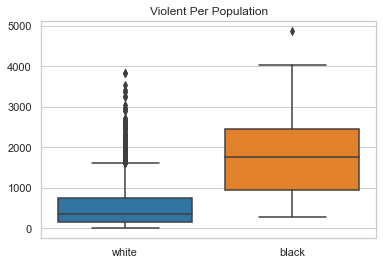

In [3]:
import seaborn as sns

x, y = df.drop(columns='violentPerPop'), df['violentPerPop']
fig = sns.boxplot(x=x['race'].map({0: 'white', 1: 'black'}), y=y)
fig.set(xlabel='', ylabel='', title='Violent Per Population');

This boxplot shows how there exists a discrimination between mainly white vs. mainly black neighbourhoods.

A simple way to understand whether this discrimination is direct (*disparate treatment*) or indirect (*disparate impact*) is to train a linear regression model and inspect the weight of the protected feature. As in the previous tutorial, we will do that leveraging the Moving Targets' APIs instead of the traditional `scikit-learn` models in order to exploit the possibility to scale the input data in a faster way via the `x_scaler` and `y_scaler` parameters.

Recall that each Moving Targets' `Learner` object is essentially a wrapper of a machine learning model, which can be accessed via its `model` field. In this case, since we are wrapping a `scikit-learn` object, we can access its fields. In particular, we are interested to understand the weight (`coef_`) of each input feature (`feature_names_in_`).

In [4]:
from moving_targets.learners import LinearRegression

learner = LinearRegression(x_scaler='std', y_scaler='norm').fit(x, y)
weights = pd.Series(learner.model.coef_, index=learner.model.feature_names_in_)
weights = weights.sort_values(key=abs, ascending=False)

print('Top 10 features:')
print()
print(weights.head(10).to_string())
print()
print(f'> race is at position {weights.index.get_loc("race")}/{len(weights)} with weight {weights["race"]:.4e}')

Top 10 features:

rentUpperQ           1.981925e+11
ownHousUperQ         1.829163e+11
rentLowQ            -1.426295e+11
ownHousLowQ         -1.240474e+11
rentQrange          -8.455192e+10
ownHousQrange       -7.150474e+10
pctAllDivorc        -1.393157e-01
pctPersOwnOccup     -1.370262e-01
pctHousOwnerOccup    1.221527e-01
pctMaleDivorc        8.685146e-02

> race is at position 53/103 with weight -7.6444e-03


As we can see, the model is focusing its predictions mainly on $6$ features, while the remaining ones (**race** included) are practically negligible for the purpose of the predictive task. Still, the discrimination is evident from the previous plots, and it is likely to be carried out by one (or more) of the other features which act as *proxies* to identify the protected group, similarly to what happens in the [redlining](https://en.wikipedia.org/wiki/Redlining) discriminatory practice.

However, in order to pose some constraint, we will need to somehow measure this level of discrimination. Due to the sensitivity and subjectivity of the task, this is still an open research area, but to the extent of our work we will rely on the **Disparate Impact Discrimination Index** for Regression Tasks ($\mbox{DIDI}_r$), which has been introduced [here](https://arxiv.org/abs/1903.10598) and is defined as follows:

$$
\mbox{DIDI}_r = \sum_{p \in P} \mid \bar{y} - \bar{y_p} \mid
$$

where $D$ is the dataset of the entire population and:
* $P$ is the domain of the protected feature and $p$ represents each protected group (e.g., $P = \{p_0=\mbox{black}, p_1=\mbox{hispanic}, p_2=\mbox{asian}, ...\}$)
* $\bar{y}$ is the average prediction on the whole population, i.e., $\bar{y} = \frac{1}{\mid D \mid} \sum_{i \in D} y_i$
* $\bar{y_p}$ is the average prediction on the protected population, i.e., $\bar{y_p} = \frac{1}{\mid D_p \mid} \sum_{i \in D_p} y_i$

Intuitively, the *DIDI* measures the sum of the deviations from the overall mean respectively to each protected group. Thus, as it approaches a zero value, it means that we are reducing the level of discrimination. Let us see which is the violation level on our dataset using the `DIDI` class which can be found inside the Moving Targets' `metric` package:

In [5]:
from moving_targets.metrics import DIDI

didi = DIDI(protected='race', classification=False, percentage=False)
print(f'DIDI: {didi(x=x, y=None, p=y)}')

DIDI: 1293.2071114749167


A pitfall of the *DIDI* is that it is an absolute metric, therefore we have no ways to know whether this is a large amount of discrimination or not. Nonetheless, we can compare different *DIDI* values to understand which of the possible target vectors is less discriminative, or even the level of discrimination of a target vector $y'$ with respect to a target vector $y$ by computing their ratio.

> This is exactly what the `percentage` parameter does: it compares the *DIDI* computed on the predictions $p$ with the *DIDI* computed on the original targets $y$ and yields their ratio. Indeed, here we passed no original targets `y` because we wanted the absolute *DIDI* value, to get the relative value we should have done:
> ```python
> didi = DIDI(protected='race', classification=False, percentage=True)
> didi(x=x, y=y, p=y)
> ```
> which in this case would yield $1.0$ because the two target vectors are the same.

Now, say that we measured a certain $\mbox{DIDI}(y)$ on our original targets. Forcing this value to be exactly zero may lead to excessively poor performances, thus we can formulate our constraint as *20% of the initial discrimination*, or rather:
$$
\mbox{DIDI}(p) \leq 0.2 * \mbox{DIDI}(y)
$$

## Moving Targets

Similarly to the class balancing problem, here we have a non-differentiable constraint which is defined over the whole population. It follows that Moving Targets might turn out to be useful when solving this task.

But first, split the data points into a train and test set and compute our reference *DIDI*.

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True)
didi_train = didi(x=x_train, y=None, p=y_train)
didi_train

1300.5910106903016

Recall the three main building blocks of the Moving Targets' library: `Learner`, `Master`, and `MACS`.

This time, we will need to subclass the `RegressionMaster` class because we are dealing with a regression task, but the interface is the same: we need to formulate the constraints within the `build` method, and optionally handle some user-specified parameters within the `__init__` one.

In particular, in this case the `__init__` method signature contains the usual `backend`, `loss`, `alpha`, and `stats` parameters, plus a `lb` an `ub` which defines the model variables lower and upper bounds, respectively. Differently from the `ClassificationMaster`, no `types` and `labelling` parameters are present, because a regression task always uses continuous targets. Finally, we have two task-specific parameters, namely `protected` and `didi`, which indicate the name of the protected feature and the maximal accepted level of (absolute) *DIDI*, respectively.

In the `build` method, instead, we proceed by computing the *DIDI* as of the original formulation. Some important things to notice are:
* the **indicator matrix**, which represents the one-hot encoded version of the protected column, is computed via the static `get_indicator_matrix` method of the `DIDI` class, and it is used to obtain the (binary) masking vectors identifying each protected group;
* the *DIDI* is the sum of the **absolute value** of the deviations from the overall mean. Computing the absolute value is costly in Mixed-Integer Programming frameworks, but in this case the absolute value can be easily linearized with two greater-than-equal constraints since we aim at reducing their sum. Whenever this is not possible, the `Backend` object provides an `abs` method for all the backends supporting this operation;
* since we cannot compute deviations in an explicit way due to the linearization of the absolute value, we need to rely on a vector of support variables, which can be initialized using the `Backend.add_<vtype>_variables` method.

In [7]:
from moving_targets.masters import RegressionMaster

class FairRegression(RegressionMaster):
    def __init__(self, protected, didi, backend='gurobi', loss='mse', alpha='harmonic', lb=0, ub=float('inf'), stats=False):
        super().__init__(backend=backend, loss=loss, alpha=alpha, lb=lb, ub=ub, stats=stats)
        self.protected = protected
        self.didi = didi

    def build(self, x, y, p):
        # 1. RETRIEVE THE VARIABLES
        z = super(FairRegression, self).build(x, y, p)

        # 2. ADD THE CONSTRAINTS
        #   > compute the indicator matrix
        indicator_matrix = DIDI.get_indicator_matrix(x=x, protected=self.protected)
        #   > add a continuous variable for each protected group
        deviations = self.backend.add_continuous_variables(len(indicator_matrix), lb=0.0, name='deviations')
        #   > compute the average output target for the whole dataset
        total_avg = self.backend.mean(z)
        for g, protected_group in enumerate(indicator_matrix):
            #   > retrieve the subset of the variables having <label> as protected feature (i.e., the protected group)
            z_protected = z[protected_group]
            if len(z_protected) == 0:
                continue
            #   > compute the average output target for the protected group
            protected_avg = self.backend.mean(z_protected)
            #   > compute the partial deviation as the absolute value (which is linearized) of the difference between
            #   > the total average samples and the average samples within the protected group
            self.backend.add_constraint(deviations[g] >= total_avg - protected_avg)
            self.backend.add_constraint(deviations[g] >= protected_avg - total_avg)
        # > eventually compute the DIDI as the sum of this deviations and constrain it
        didi = self.backend.sum(deviations)
        self.backend.add_constraint(didi <= self.didi)

        # 3. RETURN THE VARIABLES
        return z

It is now time to instantiate and fit the `MACS` object.

As well as in the previous tutorial, we pass a custom callback to the `fit` method to visually address the level of discrimination during the iterations. Also, remember that even though the input data may be in each acceptable format (e.g., lists, numpy, pandas), the Moving Targets' library always expects and returns a numpy array for the output data.

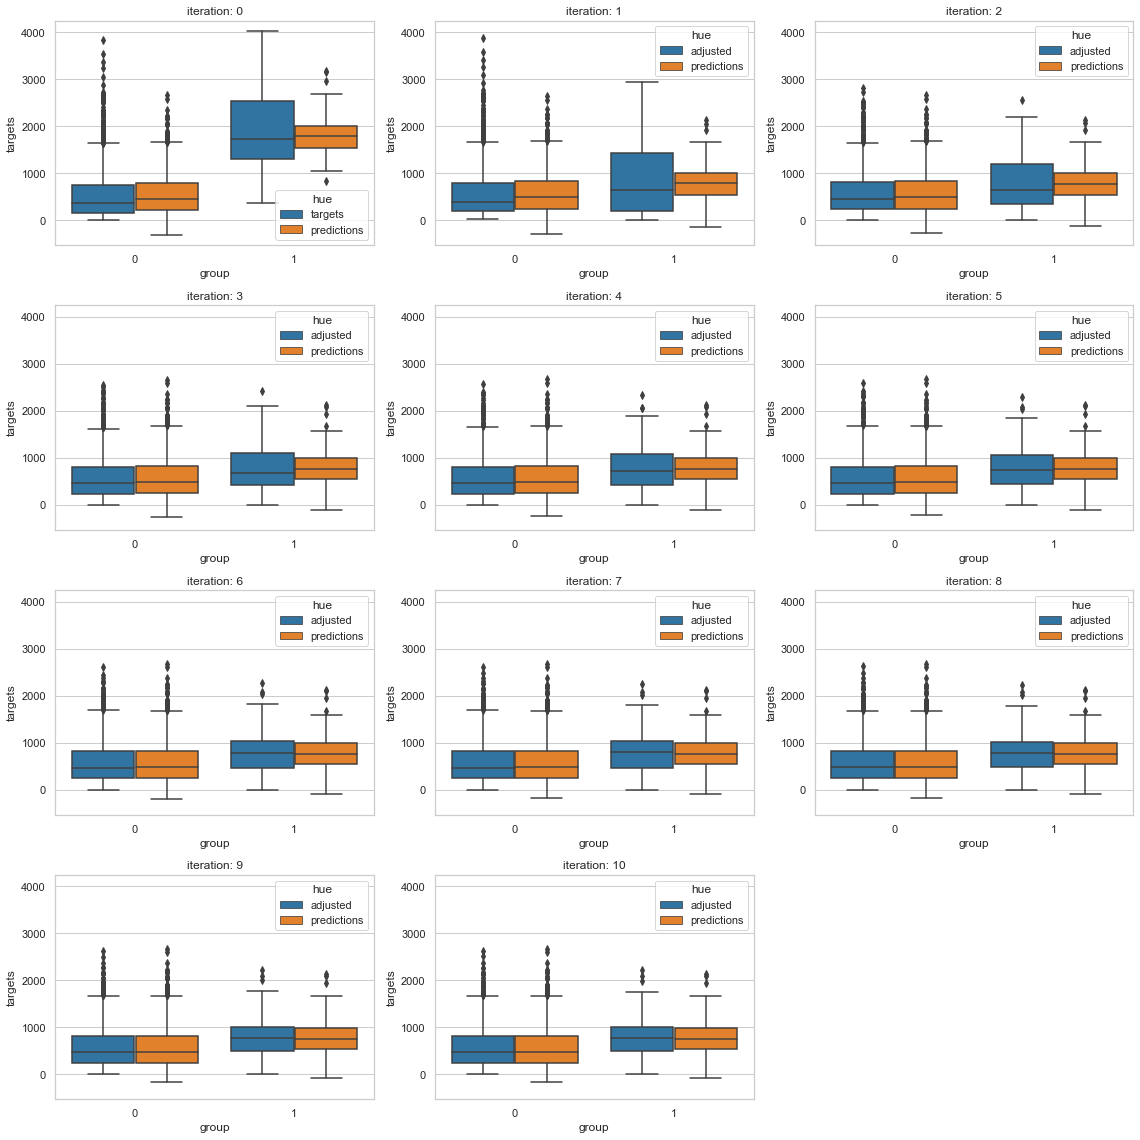

In [8]:
from moving_targets import MACS
from moving_targets.metrics import MSE, R2, DIDI
from util.fairness import RegressionCallback

master=FairRegression(protected='race', didi=0.2 * didi_train)
learner=LinearRegression(x_scaler='std', y_scaler='norm')
metrics=[MSE(), R2(), DIDI(protected='race', classification=False, percentage=True)]
model = MACS(init_step='pretraining', master=master, learner=learner, metrics=metrics)


callbacks = [RegressionCallback(protected='race', figsize=(16, 16), tight_layout=True)]
val_data = dict(test=(x_test, y_test.values))
history = model.fit(x=x_train, y=y_train.values, iterations=10, val_data=val_data, callbacks=callbacks, verbose=False)

And eventually plot the training metrics and statistics via the `History` object:

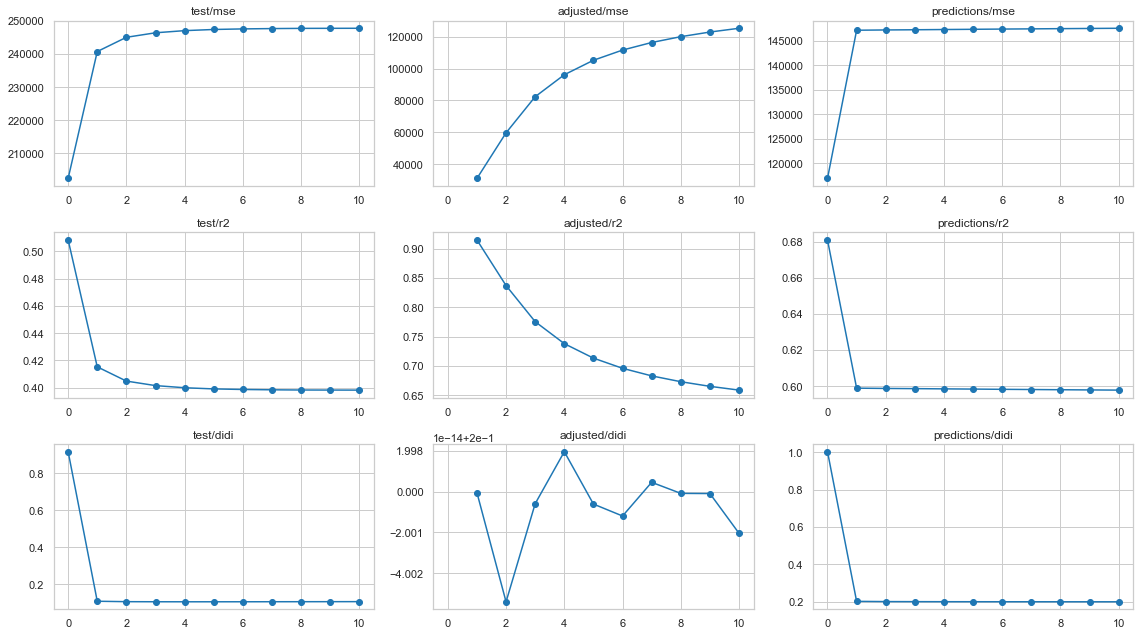

In [9]:
history.plot()

## Conclusions

We succeeded again at satisfying our constraint, not only on the training set but on the test set as well, meaning that Moving Targets owns generalization capabilities.

Obviously, this has come at the expenses of predictive accuracy, but do not overestimate the importance of accuracy metrics in a fairness-related task. Indeed, we should prefer a less powerful non-discriminative model with respect to a more accurate but more discriminative one. Additionally, whenever the training data is biased due to historically discriminative practices, to seek for a high accuracy means to replicate the same discriminative practices, which were not accurate in first place. Thanks to Moving Targets, we might be able to find the correct trade-off!